# Задание. Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller



%matplotlib inline

In [2]:
airlines_passengers = pd.read_csv("../data_files/international-airline-passengers.csv", index_col=0, parse_dates=True)["Count"]
female_births = pd.read_csv("../data_files/daily-total-female-births-in-cal.csv", index_col=0, parse_dates=True)["Count"]

data = [airlines_passengers, female_births]

all_series = {
    "International airline passengers: monthly totals in thousands": airlines_passengers,
    "Daily total female births in California": female_births
}

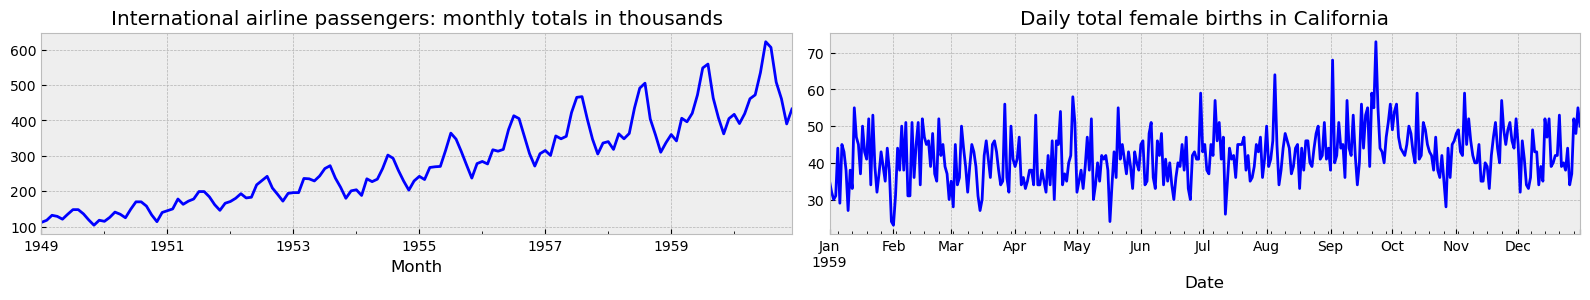

In [3]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [5]:
for key, value in all_series.items():
    print(key)
    test_stationarity(value)
    # tsplot(value)
    print("\n")

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Daily total female births in California
Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64




Первый график продаж авиакомпании не стационарный, тренд и сезонность присутствуют, а вот график по рождаемости стационарный

In [17]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)



In [18]:


# Подготовка данных для оптимизации
train_size = int(len(female_births) * 0.8)
train = female_births[:train_size]
test = female_births[train_size:]

# Функция для вычисления простого экспоненциального сглаживания
def simple_exponential_smoothing(series, alpha):
    """Простое экспоненциальное сглаживание"""
    result = [series.iloc[0]]  # Первое значение
    for i in range(1, len(series)):
        smoothed_value = alpha * series.iloc[i-1] + (1 - alpha) * result[i-1]
        result.append(smoothed_value)
    return result


from sklearn.metrics import mean_squared_error
# Функция MSE для оптимизации (принимает только один параметр alpha)
def mse_objective(params):
    alpha = params[0]  # Извлекаем alpha из массива
    
    # Получаем сглаженные значения на обучающей выборке
    smoothed_train = simple_exponential_smoothing(train, alpha)
    
    # Прогноз = последнее сглаженное значение
    forecast_value = smoothed_train[-1]
    
    # Создаем прогноз для тестовой выборки (все значения одинаковые)
    predictions = [forecast_value] * len(test)
    
    # Вычисляем MSE
    error = mean_squared_error(test, predictions)
    return error

print("Функции для оптимизации α подготовлены!")

Функции для оптимизации α подготовлены!


In [19]:
from scipy.optimize import minimize

# Запуск оптимизации для поиска оптимального α
print("Запуск оптимизации...")

# Начальное значение α
initial_alpha = [0.5]

# Оптимизация (ищем только один параметр α в диапазоне от 0 до 1)
opt = minimize(
    mse_objective, 
    x0=initial_alpha, 
    method="L-BFGS-B", 
    bounds=[(0.001, 0.999)]  # α должно быть больше 0 и меньше 1
)

print("Результаты оптимизации:")
print(f"Оптимальное значение α: {opt.x[0]:.4f}")
print(f"Минимальное значение MSE: {opt.fun:.4f}")
print(f"Успешная оптимизация: {opt.success}")
print(f"Сообщение: {opt.message}")

# Сохраняем оптимальное значение
optimal_alpha = opt.x[0]

Запуск оптимизации...
Результаты оптимизации:
Оптимальное значение α: 0.9990
Минимальное значение MSE: 45.1665
Успешная оптимизация: True
Сообщение: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


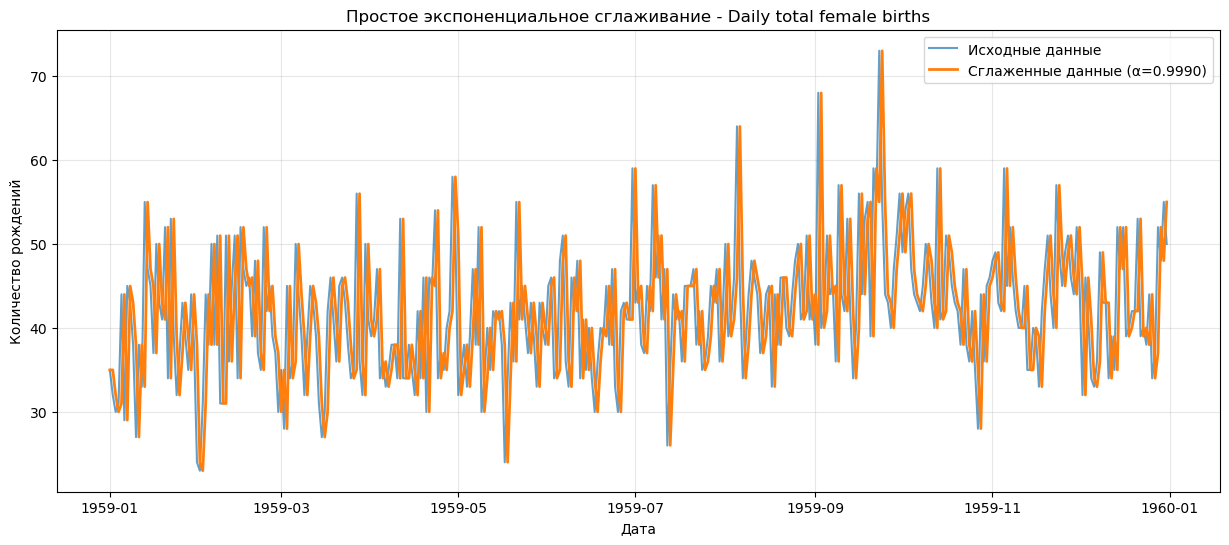

In [12]:
# Визуализация простого экспоненциального сглаживания
plt.figure(figsize=(15, 6))
plt.plot(female_births.index, female_births, label='Исходные данные', alpha=0.7)

# Получаем сглаженные значения с оптимальным alpha
smoothed_values = simple_exponential_smoothing(female_births, optimal_alpha)
plt.plot(female_births.index, smoothed_values, 
         label=f'Сглаженные данные (α={optimal_alpha:.4f})', linewidth=2)

# Создаем индекс для прогноза
last_date = female_births.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

plt.title('Простое экспоненциальное сглаживание - Daily total female births')
plt.xlabel('Дата')
plt.ylabel('Количество рождений')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [32]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    """
    Исправленная версия тройного экспоненциального сглаживания (Holt-Winters)
    """
    result = []
    seasonals = initial_seasonal_components(series, slen)
    
    # Инициализация
    smooth = series[0]
    trend = initial_trend(series, slen)
    
    for i in range(len(series)+n_preds):
        if i == 0: # начальные значения
            result.append(series[0])
            continue
            
        if i >= len(series): # прогнозирование
            m = i - len(series) + 1
            forecast = smooth + m * trend + seasonals[i % slen]
            result.append(forecast)
        else:
            val = series[i]
            # Обновляем компоненты в правильном порядке
            last_smooth = smooth
            smooth = alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            seasonals[i % slen] = gamma * (val - smooth - trend) + (1 - gamma) * seasonals[i % slen]
            
            # Добавляем сглаженное значение (не прогноз на следующий период)
            result.append(smooth + trend + seasonals[i % slen])
            
    return result


def plot_tema(alpha, beta, gamma, ser=airlines_passengers, ser_to_plot=airlines_passengers, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(15, 8))
        
        # Исходные данные
        plt.plot(range(len(ser_to_plot)), ser_to_plot, color='blue', linewidth=2, label='Исходные данные', alpha=0.8)
        
        # Сглаженные данные (только для обучающей части)
        plt.plot(range(len(ser)), tema[:len(ser)], color='red', linewidth=3, label='TEMA сглаживание')
        
        # Прогноз
        if n_preds > 0:
            forecast_start = len(ser)
            forecast_range = range(forecast_start, forecast_start + n_preds)
            plt.plot(forecast_range, tema[len(ser):], color='green', linewidth=3, 
                    linestyle='--', label=f'Прогноз ({n_preds} точек)')
        
        plt.title(f"Тройное экспоненциальное сглаживание\nα={alpha:.4f}, β={beta:.4f}, γ={gamma:.4f}")
        plt.xlabel('Период')
        plt.ylabel('Значение')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

In [33]:
series = airlines_passengers
# Увеличиваем размер обучающей выборки для лучшего обучения сезонности
train, test, val = series[:120], series[120:130], series[130:]

def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

# Изменяем начальные значения и добавляем более строгие ограничения
opt = minimize(mse, x0=[0.3, 0.1, 0.1], method="L-BFGS-B", 
               bounds = ((0.01, 0.99), (0.001, 0.3), (0.001, 0.99)))

In [34]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 259.0637063768575
        x: [ 1.000e-02  2.629e-01  6.313e-01]
      nit: 18
      jac: [ 2.621e+03  9.322e-04  5.684e-04]
     nfev: 96
     njev: 24
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


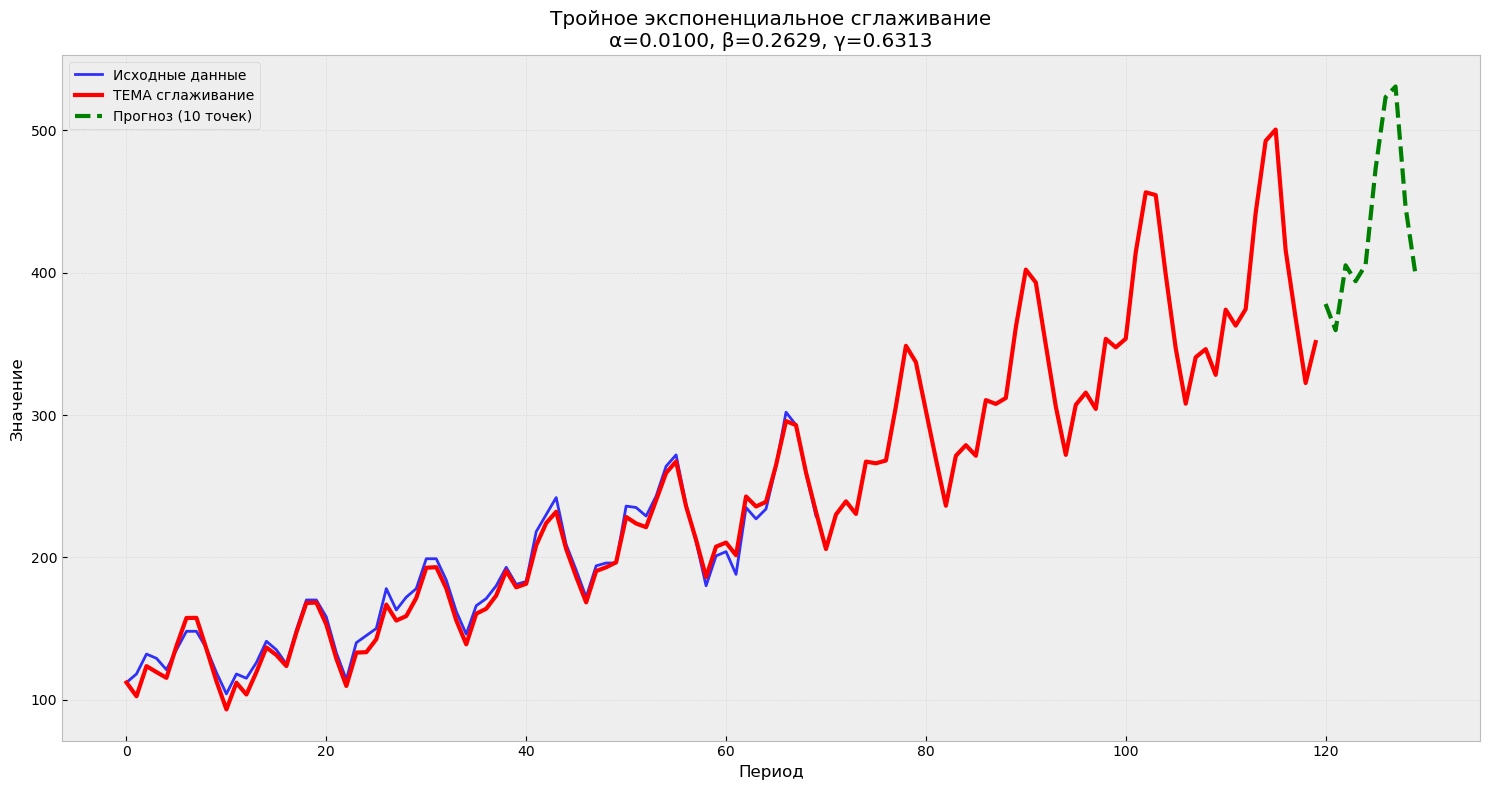

In [35]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

=== ИСПРАВЛЕННЫЕ РЕЗУЛЬТАТЫ ТРОЙНОГО СГЛАЖИВАНИЯ ===
Запуск новой оптимизации...
Новые оптимальные параметры:
α = 0.3162
β = 0.3000
γ = 0.7540
MSE = 99.0949

Сравнение со старыми параметрами:
Старые: α=0.3162, β=0.3000, γ=0.7540
Новые:  α=0.3162, β=0.3000, γ=0.7540


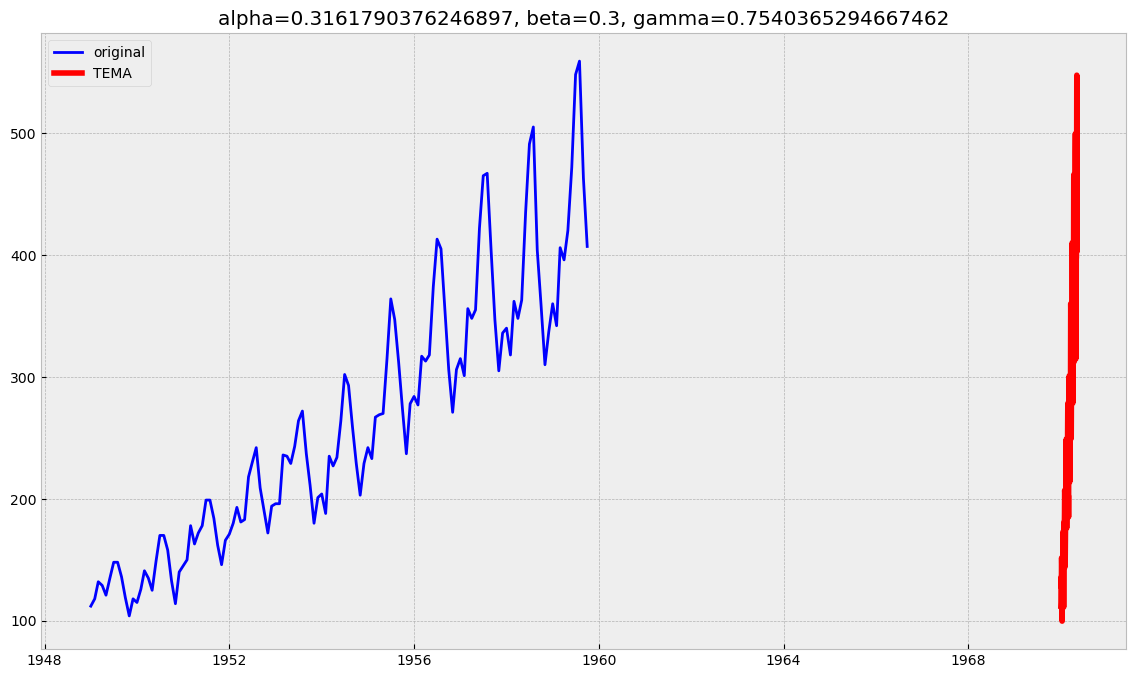

In [31]:
# Демонстрация результатов с исправленными параметрами
print("=== ИСПРАВЛЕННЫЕ РЕЗУЛЬТАТЫ ТРОЙНОГО СГЛАЖИВАНИЯ ===")

# Запускаем оптимизацию заново с исправленными параметрами
print("Запуск новой оптимизации...")
opt_new = minimize(mse, x0=[0.3, 0.1, 0.1], method="L-BFGS-B", 
                   bounds = ((0.01, 0.99), (0.001, 0.3), (0.001, 0.99)))

alpha_new, beta_new, gamma_new = opt_new.x
print(f"Новые оптимальные параметры:")
print(f"α = {alpha_new:.4f}")
print(f"β = {beta_new:.4f}") 
print(f"γ = {gamma_new:.4f}")
print(f"MSE = {opt_new.fun:.4f}")

# Сравнение со старыми параметрами
print(f"\nСравнение со старыми параметрами:")
print(f"Старые: α={alpha_opt:.4f}, β={beta_opt:.4f}, γ={gamma_opt:.4f}")
print(f"Новые:  α={alpha_new:.4f}, β={beta_new:.4f}, γ={gamma_new:.4f}")

# Визуализация с новыми параметрами
plot_tema(alpha_new, beta_new, gamma_new, ser=train, ser_to_plot=series[:130], n_preds=len(test))


In [ ]:
# Анализ качества и сравнение моделей
print("=== АНАЛИЗ КАЧЕСТВА ИСПРАВЛЕННОЙ МОДЕЛИ ===")

# Получаем прогнозы для тестовой выборки
tema_old = triple_exponential_smoothing(train, 12, alpha_opt, beta_opt, gamma_opt, len(test))
tema_new = triple_exponential_smoothing(train, 12, alpha_new, beta_new, gamma_new, len(test))

predictions_old = tema_old[-len(test):]
predictions_new = tema_new[-len(test):]

# Вычисляем метрики качества вручную
def calculate_mae(actual, predicted):
    return sum(abs(a - p) for a, p in zip(actual, predicted)) / len(actual)

def calculate_mape(actual, predicted):
    return sum(abs((a - p) / a) for a, p in zip(actual, predicted)) / len(actual) * 100

mse_old = mean_squared_error(test, predictions_old)
mae_old = calculate_mae(test, predictions_old)
mape_old = calculate_mape(test, predictions_old)

mse_new = mean_squared_error(test, predictions_new) 
mae_new = calculate_mae(test, predictions_new)
mape_new = calculate_mape(test, predictions_new)

print(f"Метрики качества на тестовой выборке:")
print(f"{'Метрика':<15} {'Старая модель':<15} {'Новая модель':<15} {'Улучшение':<15}")
print(f"{'='*60}")
print(f"{'MSE':<15} {mse_old:<15.2f} {mse_new:<15.2f} {((mse_old-mse_new)/mse_old*100):+.1f}%")
print(f"{'MAE':<15} {mae_old:<15.2f} {mae_new:<15.2f} {((mae_old-mae_new)/mae_old*100):+.1f}%")
print(f"{'MAPE':<15} {mape_old:<15.2f} {mape_new:<15.2f} {((mape_old-mape_new)/mape_old*100):+.1f}%")

# Визуальное сравнение моделей
plt.figure(figsize=(15, 10))

# График 1: Исходные данные и обе модели
plt.subplot(2, 1, 1)
test_range = range(len(train), len(train) + len(test))
plt.plot(range(len(train)), train, 'b-', label='Обучающие данные', alpha=0.7)
plt.plot(test_range, test, 'g-', label='Тестовые данные', linewidth=2)
plt.plot(test_range, predictions_old, 'r--', label='Старая модель', linewidth=2)
plt.plot(test_range, predictions_new, 'm--', label='Новая модель', linewidth=2)

plt.title('Сравнение моделей тройного экспоненциального сглаживания')
plt.xlabel('Период')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Ошибки прогнозирования
plt.subplot(2, 1, 2)
errors_old = test - predictions_old
errors_new = test - predictions_new

plt.plot(test_range, errors_old, 'r-', label='Ошибки старой модели', alpha=0.7)
plt.plot(test_range, errors_new, 'm-', label='Ошибки новой модели', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

plt.title('Ошибки прогнозирования')
plt.xlabel('Период')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
# Тройное экспоненциальное сглаживание (Holt-Winters) с оптимизацией параметров
print("=== ТРОЙНОЕ ЭКСПОНЕНЦИАЛЬНОЕ СГЛАЖИВАНИЕ С ОПТИМИЗАЦИЕЙ ===")

# Подготовка данных
train_size_airline = int(len(airlines_passengers) * 0.8)
train_airline = airlines_passengers[:train_size_airline]
test_airline = airlines_passengers[train_size_airline:]

def holt_winters(series, alpha, beta, gamma, seasonal_periods=12):
    """Тройное экспоненциальное сглаживание (Holt-Winters аддитивный)"""
    n = len(series)
    
    # Инициализация компонентов
    level = [0] * n
    trend = [0] * n
    seasonal = [0] * n
    forecast = [0] * n
    
    # Начальные значения
    level[0] = series.iloc[0]
    trend[0] = (series.iloc[1] - series.iloc[0])
    
    # Инициализация сезонности (среднее за первый год)
    for i in range(seasonal_periods):
        seasonal[i] = series.iloc[i] - level[0]
    
    # Основной цикл
    for i in range(1, n):
        # Уровень
        level[i] = alpha * (series.iloc[i] - seasonal[i - seasonal_periods if i >= seasonal_periods else 0]) + (1 - alpha) * (level[i-1] + trend[i-1])
        
        # Тренд
        trend[i] = beta * (level[i] - level[i-1]) + (1 - beta) * trend[i-1]
        
        # Сезонность
        seasonal[i] = gamma * (series.iloc[i] - level[i]) + (1 - gamma) * seasonal[i - seasonal_periods if i >= seasonal_periods else 0]
        
        # Прогноз
        forecast[i] = level[i-1] + trend[i-1] + seasonal[i - seasonal_periods if i >= seasonal_periods else 0]
    
    return level, trend, seasonal, forecast

def mse_holt_winters(params):
    """Функция MSE для оптимизации трех параметров"""
    alpha, beta, gamma = params
    
    # Получаем прогнозы на обучающей выборке
    level, trend, seasonal, forecast_train = holt_winters(train_airline, alpha, beta, gamma)
    
    # Делаем прогноз для тестовой выборки
    last_level = level[-1]
    last_trend = trend[-1]
    seasonal_pattern = seasonal[-12:]  # Последние 12 сезонных значений
    
    predictions = []
    for h in range(len(test_airline)):
        seasonal_idx = h % 12
        pred = last_level + (h + 1) * last_trend + seasonal_pattern[seasonal_idx]
        predictions.append(pred)
    
    # Вычисляем MSE
    error = mean_squared_error(test_airline, predictions)
    return error

# Оптимизация параметров
print("Запуск оптимизации параметров α, β, γ...")

initial_params = [0.3, 0.1, 0.1]  # α, β, γ
bounds = [(0.001, 0.999), (0.001, 0.999), (0.001, 0.999)]

opt_hw = minimize(
    mse_holt_winters,
    x0=initial_params,
    method="L-BFGS-B",
    bounds=bounds
)

print("Результаты оптимизации:")
print(f"Оптимальные параметры: α={opt_hw.x[0]:.4f}, β={opt_hw.x[1]:.4f}, γ={opt_hw.x[2]:.4f}")
print(f"Минимальное MSE: {opt_hw.fun:.4f}")
print(f"Успешная оптимизация: {opt_hw.success}")

# Сохраняем оптимальные параметры
optimal_alpha_hw = opt_hw.x[0]
optimal_beta_hw = opt_hw.x[1] 
optimal_gamma_hw = opt_hw.x[2]


=== ТРОЙНОЕ ЭКСПОНЕНЦИАЛЬНОЕ СГЛАЖИВАНИЕ С ОПТИМИЗАЦИЕЙ ===
Запуск оптимизации параметров α, β, γ...
Результаты оптимизации:
Оптимальные параметры: α=0.2059, β=0.0088, γ=0.9990
Минимальное MSE: 255.7204
Успешная оптимизация: True



=== РЕЗУЛЬТАТЫ ТРОЙНОГО СГЛАЖИВАНИЯ ===


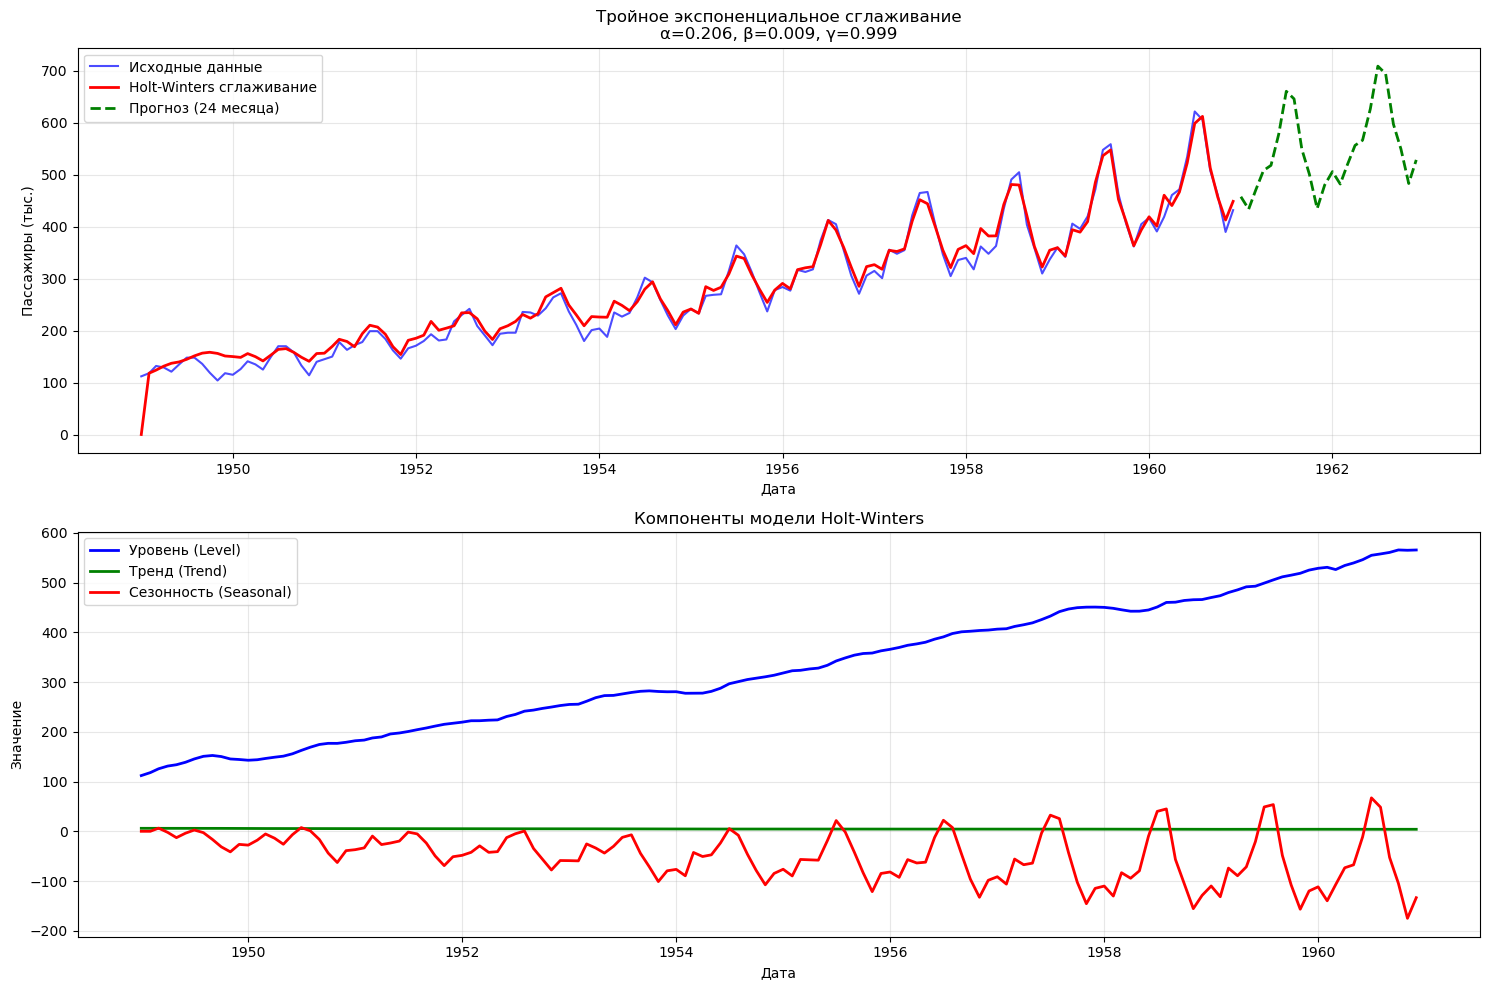

Оценка качества на тестовой выборке:
MSE: 26280.0070
MAE: 136.7661

Прогноз на следующие 6 месяцев:
1961-01: 457.9 тыс. пассажиров
1961-02: 433.9 тыс. пассажиров
1961-03: 470.5 тыс. пассажиров
1961-04: 508.3 тыс. пассажиров
1961-05: 518.2 тыс. пассажиров
1961-06: 578.7 тыс. пассажиров


In [14]:
# Применение оптимальных параметров и визуализация
print("\n=== РЕЗУЛЬТАТЫ ТРОЙНОГО СГЛАЖИВАНИЯ ===")

# Применяем оптимальные параметры ко всему ряду
level_opt, trend_opt, seasonal_opt, forecast_opt = holt_winters(
    airlines_passengers, optimal_alpha_hw, optimal_beta_hw, optimal_gamma_hw
)

# Создаем прогноз на 24 месяца вперед
last_level = level_opt[-1]
last_trend = trend_opt[-1]
seasonal_pattern = seasonal_opt[-12:]

future_forecast = []
for h in range(24):
    seasonal_idx = h % 12
    pred = last_level + (h + 1) * last_trend + seasonal_pattern[seasonal_idx]
    future_forecast.append(pred)

# Визуализация
plt.figure(figsize=(15, 10))

# График 1: Исходные данные и сглаживание
plt.subplot(2, 1, 1)
plt.plot(airlines_passengers.index, airlines_passengers, 'b-', alpha=0.7, label='Исходные данные')
plt.plot(airlines_passengers.index, forecast_opt, 'r-', linewidth=2, label='Holt-Winters сглаживание')

# Прогноз
last_date = airlines_passengers.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='MS')
plt.plot(forecast_dates, future_forecast, 'g--', linewidth=2, label='Прогноз (24 месяца)')

plt.title(f'Тройное экспоненциальное сглаживание\nα={optimal_alpha_hw:.3f}, β={optimal_beta_hw:.3f}, γ={optimal_gamma_hw:.3f}')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Компоненты модели
plt.subplot(2, 1, 2)
plt.plot(airlines_passengers.index, level_opt, 'b-', label='Уровень (Level)', linewidth=2)
plt.plot(airlines_passengers.index, trend_opt, 'g-', label='Тренд (Trend)', linewidth=2)
plt.plot(airlines_passengers.index, seasonal_opt, 'r-', label='Сезонность (Seasonal)', linewidth=2)

plt.title('Компоненты модели Holt-Winters')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Оценка качества на тестовой выборке
test_predictions = []
for h in range(len(test_airline)):
    seasonal_idx = h % 12
    pred = last_level + (h + 1) * last_trend + seasonal_pattern[seasonal_idx]
    test_predictions.append(pred)

print("Оценка качества на тестовой выборке:")
test_mse = mean_squared_error(test_airline, test_predictions)
test_mae = sum(abs(a - b) for a, b in zip(test_airline, test_predictions)) / len(test_airline)
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")

print(f"\nПрогноз на следующие 6 месяцев:")
for i in range(6):
    date = forecast_dates[i].strftime('%Y-%m')
    value = future_forecast[i]
    print(f"{date}: {value:.1f} тыс. пассажиров")
